# Project 4: West Nile Virus Prediction


## Contents:
- [Data](#Data)
- [Model](#Model)
- [Feature reduction](#Feature-reduction)
- [Feature extraction](#Feature-extraction)
- [Conclusions](#Conclusions)


In [59]:
# Import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import (RidgeCV, 
                                  LassoCV, 
                                  ElasticNetCV, 
                                  LogisticRegressionCV,
                                  LinearRegression,
                                  LogisticRegression)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, 
                             plot_confusion_matrix, 
                             roc_auc_score, 
                             plot_roc_curve, 
                             accuracy_score)
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC

import xgboost as xgb
from xgboost import XGBClassifier

import time
import warnings
warnings.filterwarnings('ignore')

# Data

**Data** 
* train_set.csv: this is the training dataset
* test_set.csv: this is the test dataset

In [2]:
train = pd.read_csv('../data/train_set.csv')
# train = pd.read_csv('../datasets/clean-data/train_set.csv')

In [3]:
test = pd.read_csv('../data/test_set.csv')
# test = pd.read_csv('../datasets/clean-data/test_set.csv')

In [4]:
# preview train set
train

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,avgspeed,temp_diff,week,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,2,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,1,1,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8458,2013-09-26,3.0,41.973845,-87.805059,9,1,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8459,2013-09-26,3.0,41.974689,-87.890615,9,37,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0


In [5]:
train.shape

(8461, 31)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8461 entries, 0 to 8460
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               8461 non-null   object 
 1   species_nr         8461 non-null   float64
 2   latitude           8461 non-null   float64
 3   longitude          8461 non-null   float64
 4   addressaccuracy    8461 non-null   int64  
 5   nummosquitos       8461 non-null   int64  
 6   wnvpresent         8461 non-null   int64  
 7   trap_rank          8461 non-null   int64  
 8   tmax               8461 non-null   float64
 9   tmin               8461 non-null   float64
 10  tavg               8461 non-null   float64
 11  depart             8461 non-null   float64
 12  dewpoint           8461 non-null   float64
 13  wetbulb            8461 non-null   float64
 14  sunrise            8461 non-null   float64
 15  sunset             8461 non-null   float64
 16  preciptotal        8461 

In [7]:
# change date to numerical
train['date'] = pd.to_datetime(train['date'])

In [8]:
# preview test set
test.head()

,id,date,latitude,longitude,addressaccuracy,species_nr,trap_rank,tmax,tmin,tavg,...,avgspeed,temp_diff,week,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,1,2008-06-11,41.95469,-87.800991,9,2.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
1,2,2008-06-11,41.95469,-87.800991,9,1.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
2,3,2008-06-11,41.95469,-87.800991,9,3.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
3,4,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095
4,5,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,10.2,9.75,24.0,2008.0,0.0,0.0,66.5,72.75,0.0,0.095


In [9]:
test.shape

(116293, 30)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 116293 non-null  int64  
 1   date               116293 non-null  object 
 2   latitude           116293 non-null  float64
 3   longitude          116293 non-null  float64
 4   addressaccuracy    116293 non-null  int64  
 5   species_nr         116293 non-null  float64
 6   trap_rank          116293 non-null  int64  
 7   tmax               116293 non-null  float64
 8   tmin               116293 non-null  float64
 9   tavg               116293 non-null  float64
 10  depart             116293 non-null  float64
 11  dewpoint           116293 non-null  float64
 12  wetbulb            116293 non-null  float64
 13  sunrise            116293 non-null  float64
 14  sunset             116293 non-null  float64
 15  preciptotal        116293 non-null  float64
 16  st

In [11]:
# change date to numerical
test['date'] = pd.to_datetime(test['date'])

In [12]:
# baseline score
train['wnvpresent'].value_counts()

0     8004
1      409
2       31
3        9
4        2
8        1
9        1
10       1
5        1
6        1
7        1
Name: wnvpresent, dtype: int64

In [13]:
# convert to binary
# 0 means no wnv detected
# 1 means wnv detected
def rebin_wnvpresent(row): 
    if row['wnvpresent'] > 0:
        row['wnvpresent'] = 1
    else:
        row['wnvpresent'] = 0
    return row

In [14]:
train = train.apply(rebin_wnvpresent,axis=1)

In [15]:
train['wnvpresent'].value_counts()

0    8004
1     457
Name: wnvpresent, dtype: int64

# Model

## Baseline model (with SMOTE)

Let's just start with modeling using one feature. Since 'trap_rank', 'species_nr' has the largest correlation to 'wnvpresent', the feature will be used. Simplest classification method would be the logistic regression model. 

In [16]:
X_sm = train[['species_nr']]
y_sm = train[['wnvpresent']]

In [17]:
y=train[['wnvpresent']]

In [18]:
# split data
Xsm_train, Xsm_valid, ysm_train, ysm_valid = train_test_split(X_sm, y_sm, test_size = 0.33, random_state = 42, stratify=y)

In [19]:
# scaling
ss = StandardScaler()

Xsm_train_sc = ss.fit_transform(Xsm_train)
Xsm_valid_sc = ss.transform(Xsm_valid)

In [20]:
# instantiate
lr = LogisticRegression()

# fit model
lr.fit(Xsm_train_sc, ysm_train)

# score
lr.score(Xsm_train_sc, ysm_train), lr.score(Xsm_valid_sc, ysm_valid)

(0.9460127028934369, 0.9459362692445399)

In [21]:
ysm_train.value_counts()

wnvpresent
0             5362
1              306
dtype: int64

Using only one feature, regardless which one feature, would result in high R2 score. This is because the predictive feature is imbalanced in the training set.

**with SMOTE**

In [22]:
# create synthetic data for training set

smote = SMOTE()

# Xsmote_train, ysmote_train = smote.fit_sample(Xsm_train_sc, ysm_train)
Xsmote_train, ysmote_train = smote.fit_resample(Xsm_train_sc, ysm_train)

In [23]:
smote.fit

<bound method SamplerMixin.fit of SMOTE()>

In [24]:
ysmote_train.value_counts()

wnvpresent
0             5362
1             5362
dtype: int64

Now, the predictive feature is more balanced.

In [25]:
# instantiate
lr2 = LogisticRegression()

# fit model
lr2.fit(Xsmote_train, ysmote_train)

# score
lr2.score(Xsmote_train, ysmote_train), lr2.score(Xsm_valid_sc, ysm_valid)

(0.5987504662439388, 0.7608306480486932)

### Logistic regression model (with SMOTE)

In [26]:
# columns of train with polynomial features
train

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,avgspeed,temp_diff,week,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,6.95,10.25,22.0,2007.0,0.0,0.0,56.25,73.25,0.345,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,2013-09-26,3.0,41.960616,-87.777189,9,2,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8457,2013-09-26,3.0,41.964242,-87.757639,8,3,1,1,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8458,2013-09-26,3.0,41.973845,-87.805059,9,1,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0
8459,2013-09-26,3.0,41.974689,-87.890615,9,37,0,0,75.0,52.5,...,4.40,-1.25,39.0,2013.0,0.0,0.0,70.00,61.50,0.460,0.0


In [27]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [28]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

In [29]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])

In [30]:
# regardless of parameters, there is overfitting.
pipe_params = {
    'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    'sampling__k_neighbors': [250],   # tried 1-10000
    'logreg__penalty': ['l2', 'l1'],   # tried 'l2', 'l1', 'elastinet'
    'logreg__C': [1] # tried 1-20
}

In [31]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [32]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1], 'logreg__penalty': ['l2', 'l1'],
                         'sampling__k_neighbors': [250],
                         'sampling__sampling_strategy': ['minority',
                                                         'not minority',
                                                         'auto']},
             scoring='roc_auc')

In [33]:
grid.best_params_

{'logreg__C': 1,
 'logreg__penalty': 'l2',
 'sampling__k_neighbors': 250,
 'sampling__sampling_strategy': 'not minority'}

In [34]:
grid.score(X_train, y_train), grid.score(X_valid, y_valid)

(0.9999744022935545, 1.0)

Regardless of pipe_params used, there is overfitting. There is a lot of multicollinearity, and features have to be dropped before modeling.

Since there might be too many variables with high multicollinearity, we need to reduce number of features and/or utilise PCA to transform the data first. In such a case, we can use PCA to identify and keep those potential important relationships, before performing the predictions/models. 

## Feature reduction

We conduct several models based on a reduced number of features.

**Drop Column: ```Week``` & ```Date```**

While our graphs had provided meaningful visualization as to the prevalence of mosquitos and presence of WNV in weekly periods, we have dropped this variable in testing our logistic models. Mosquitos do not adhere to our human-based calendar groupings such as 'week' and 'date'; their activities are influenced by weather patterns. Due to climate change, weather patterns have shifted such that static human-based calendar groupings are not a precise indicator of seasons. For instance, while 'Summer' starts on June 21, the weather in June 21, 1990 is different than that of June 21, 2021. As static human-based groupings do not affect mosquito life cycle and activity, we believe that excluding such features would provide us with more accurate results.

We had also taken an into account our preliminary models in dropping these columns. In running our preliminary models including human-based calendar groupings, we found that as the most important feature, 'week' held a significant weight (143x) when compared to the second and third-most important feature, wetbulb and stnpressure (35x and 17x respectively). This means that as week increases by one, the probability of a trap capturing a WNV-infected mosquito is 143 times more likely, whereas an increase in one degree (Fahrenheit) in wetbulb or an increase of one inch in mercury-based measurement (Hg) results in a 35x and 17x likelihood of a WNV mosquito being present. Due to this massive difference in magnitude between the most important feature as compared to the rest, we believe that it is unwise to include the 'week' feature in our model.


**Drop Columns: ```Wnvpresent``` & ```Nummosquitos```**

We dropped the columns ```wnvpresent``` and ```nummosquitos``` as they are our target variables and should not be included in our training set.

**Drop Columns: ```Tmin``` & ```Tmax```**

We dropped the columns ```Tmin``` and ```Tmax``` due to multicollinearity with ```Tavg```. We believe that ```Tavg``` provides us a better gauge of the day's temperature rather than using the minimum and maximum temperature of the day.

**Drop Column: ```trap_rank```**

We dropped ```trap_rank``` as this is our engineered feature based on our target variables. Including this feature in our model would result in leakage to our data and this will result in an overfitting of our training models.

In [35]:
X = train.drop(columns=['week', 'date', 'wnvpresent', 'nummosquitos',
                        'tmin', 'tmax', 'trap_rank'])

y = train['wnvpresent'].map(lambda x:0 if x == 0 else 1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y
                                                   )

In [37]:
kaggle_X = test[['species_nr', 'latitude', 'longitude', 'addressaccuracy', 'tavg', 
                 'depart', 'dewpoint', 'wetbulb', 'sunrise', 'sunset', 'preciptotal', 
                 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 
                 'temp_diff', 'year', 'FG', 'TS', 'lag_1_tavg', 'lag_2_tavg', 
                 'lag_1_preciptotal', 'lag_2_preciptotal']]

### Loop models

In [38]:
result = pd.DataFrame()
result_columns = ['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'ROC_AUC']


In [39]:
def gs_model(gs_name, model_name):
    global result
    duration = time.time()
    gs_name.fit(X_train, y_train)
    tn, fp, fn, tp = confusion_matrix(y_test, gs_name.predict(X_test)).ravel()
    accuracy = round((tp+tn)/(tn+fp+fn+tp),3)*100 
    sensitivity = round((tp)/(tp+fn),3)*100
    specificity = round(tn/(tn+fp),3)*100
    roc_auc = round(roc_auc_score(y_test, gs_name.best_estimator_.predict(X_test)),3)
    
    result_new = pd.DataFrame([model_name, 
                               accuracy,
                               sensitivity,
                               specificity,
                               roc_auc
                               ], index=result_columns).T
    
    result = pd.concat(objs=(result, result_new), axis=0)
    
    plot_confusion_matrix(gs_name, 
                          X_test, y_test, 
                          cmap='Blues', 
                          values_format='d',
                          display_labels=['No WNV', 'WNV']
                         );
    plt.title(model_name)
    print(f'Model Best Params: {gs_name.best_params_}')
    print(f'Process took {round((time.time()-duration)/60,1)} minutes')
    return result.set_index('Model')

### Logistic Classifier Models

We conduct several classifier models based on different penalization methods and classifier models.

#### SS, Smote, Logistic (Ridge)

In [40]:
smote = SMOTE()
ss = StandardScaler()
logit = LogisticRegressionCV()

pipe_ss_smote_logit_ridge = Pipeline([
    ('ss', ss),
    ('smote', smote),
    ('logit', logit),
])

pipe_ss_smote_logit_ridge_params = {
    'smote__k_neighbors': [5], # 3, 10, 15
    'smote__random_state': [42],
    'smote__n_jobs': [-1],
    'smote__sampling_strategy': ['minority'],
    'logit__cv': [15], #5, 10, 20, 25
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__scoring': ['roc_auc'],
    'logit__solver': ['saga'],
    'logit__max_iter': [10_000],
}

gs_ss_smote_logit_ridge = GridSearchCV(
    estimator=pipe_ss_smote_logit_ridge,
    param_grid=pipe_ss_smote_logit_ridge_params,
    cv=5
)

Model Best Params: {'logit__cv': 15, 'logit__max_iter': 10000, 'logit__n_jobs': -1, 'logit__random_state': 42, 'logit__scoring': 'roc_auc', 'logit__solver': 'saga', 'smote__k_neighbors': 5, 'smote__n_jobs': -1, 'smote__random_state': 42, 'smote__sampling_strategy': 'minority'}
Process took 1.1 minutes


,Accuracy,Sensitivity,Specificity,ROC_AUC
Model,,,,
"SS, Smote, Logit-Ridge",72.5,73.7,72.5,0.731


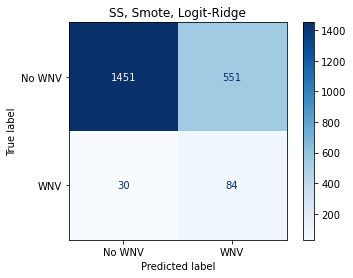

In [41]:
gs_model(gs_ss_smote_logit_ridge, 'SS, Smote, Logit-Ridge')

**Observations and Interpretation of Feature Importance**


In [42]:
feat_impt = pd.DataFrame(
    gs_ss_smote_logit_ridge.best_estimator_['logit'].coef_[0], 
    index=X_train.columns)

logit_ridge_head = pd.DataFrame(np.exp(feat_impt[0].sort_values(ascending=False).head(5))).T
logit_ridge_tail = pd.DataFrame(np.exp(feat_impt[0].sort_values(ascending=False).tail(5))).T

display(logit_ridge_head, logit_ridge_tail)

,sunrise,temp_diff,tavg,wetbulb,stnpressure
0,13.564643,5.285333,5.285333,2.250174,2.187374


,preciptotal,longitude,sealevel,dewpoint,depart
0,0.669538,0.58882,0.583417,0.364087,0.074038


We find that the features we used to create out models have differing magnitudes of impact.
As the sun rises later, there is a much higher likelihood of observing a WNV-infected mosquito.
In any given day, an increase in one minute in the sunrise time results in a 13.6x likelihood of a WNV-infected mosquito to be found.
An increase of 1 Fahrenheit in average temperature results in a 5.3x likelihood of a WNV-infected mosquito to be found.
Precipitation negatively affects the likelihood of observing a WNV-infected mosquito.
An increase in precipitation by 1 inch results in a 0.67x likelihood of a WNV-infected mosquito to be found.
The positive relationship in average temperature and inverse relationship in precipitation is similar to that we have identified in our previous EDA.

#### SS, Smote, Logistic (Lasso)

In [43]:
smote = SMOTE()
ss = StandardScaler()
logit = LogisticRegressionCV()

pipe_ss_smote_logit_lasso = Pipeline([
    ('ss', ss),
    ('smote', smote),
    ('logit', logit),
])

pipe_ss_smote_logit_lasso_params = {
    'smote__k_neighbors': [3], # 5, 10, 15
    'smote__random_state': [42],
    'smote__n_jobs': [-1],
    'smote__sampling_strategy': ['minority'],
    'logit__cv': [20], # 5, 10, 15, 25
    'logit__n_jobs': [-1],
    'logit__random_state': [42],
    'logit__scoring': ['roc_auc'],
    'logit__solver': ['saga'],
    'logit__max_iter': [10_000],
    'logit__penalty': ['l1'],
#     'logit__l1_ratios': [num for num in np.logspace(-3, 3, 20)]
}

gs_ss_smote_logit_lasso = GridSearchCV(
    estimator=pipe_ss_smote_logit_lasso,
    param_grid=pipe_ss_smote_logit_lasso_params,
    cv=5
)

Model Best Params: {'logit__cv': 20, 'logit__max_iter': 10000, 'logit__n_jobs': -1, 'logit__penalty': 'l1', 'logit__random_state': 42, 'logit__scoring': 'roc_auc', 'logit__solver': 'saga', 'smote__k_neighbors': 3, 'smote__n_jobs': -1, 'smote__random_state': 42, 'smote__sampling_strategy': 'minority'}
Process took 1.7 minutes


,Accuracy,Sensitivity,Specificity,ROC_AUC
Model,,,,
"SS, Smote, Logit-Ridge",72.5,73.7,72.5,0.731
"SS, Smote, Logit-Lasso",73.1,74.6,73.0,0.738


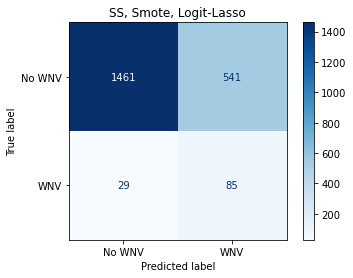

In [44]:
gs_model(gs_ss_smote_logit_lasso, 'SS, Smote, Logit-Lasso')

**Observations and Interpretation of Feature Importance**

In [45]:
feat_impt = pd.DataFrame(
    gs_ss_smote_logit_lasso.best_estimator_['logit'].coef_[0], 
    index=X_train.columns)

logit_lasso_head = pd.DataFrame(np.exp(feat_impt[0].sort_values(ascending=False).head(5))).T
logit_lasso_tail = pd.DataFrame(np.exp(feat_impt[0].sort_values(ascending=False).tail(5))).T

display(logit_lasso_head, logit_lasso_tail)

,sunrise,temp_diff,tavg,stnpressure,TS
0,13.020677,5.511193,5.511193,3.191687,1.981297


,preciptotal,longitude,dewpoint,sealevel,depart
0,0.66596,0.570535,0.414168,0.362066,0.072401


We find that the features we used to create out models have differing magnitudes of impact.
As the sun rises later, there is a much higher likelihood of observing a WNV-infected mosquito.
In any given day, an increase in one minute in the sunrise time results in a 13x likelihood of a WNV-infected mosquito to be found.
An increase of 1 Fahrenheit in average temperature results in a 5.5x likelihood of a WNV-infected mosquito to be found.
Precipitation negatively affects the likelihood of observing a WNV-infected mosquito.
An increase in precipitation by 1 inch results in a 0.67x likelihood of a WNV-infected mosquito to be found.
The positive relationship in average temperature and inverse relationship in precipitation is similar to that we have identified in our previous EDA.

#### Logistic Classifier Model Combined

In [46]:
logit_combined_head = pd.concat(objs=(logit_ridge_head, logit_lasso_head), axis=0).reset_index(drop=True)
logit_combined_head.index = ['Ridge Head', 'Lasso Head']

logit_combined_tail = pd.concat(objs=(logit_ridge_tail, logit_lasso_tail), axis=0).reset_index(drop=True)
logit_combined_tail.index = ['Ridge Tail', 'Lasso Tail']

display(logit_combined_head)
display(logit_combined_tail)

,sunrise,temp_diff,tavg,wetbulb,stnpressure,TS
Ridge Head,13.564643,5.285333,5.285333,2.250174,2.187374,NaN
Lasso Head,13.020677,5.511193,5.511193,NaN,3.191687,1.981297


,preciptotal,longitude,sealevel,dewpoint,depart
Ridge Tail,0.669538,0.588820,0.583417,0.364087,0.074038
Lasso Tail,0.665960,0.570535,0.362066,0.414168,0.072401


**Feature Importance Comparison**

We compare the feature importances of the top 5 heads and tails between our model.

We find that 4 out of 5 of the top head features used in the logistic classification model are identical.
However, there is a difference in magnitude of effect. The magnitudes in the lasso features are more evenly distributed than the ridge feature importances.
The difference in magnitude is caused by the different types of penalization between the two regularization models.
We find that all 5 of the top tail features used in the logistic classification model are identical.
However, similar to #2, there is a difference in the magnitude of effect. 

In [47]:
display(result.set_index('Model'))

,Accuracy,Sensitivity,Specificity,ROC_AUC
Model,,,,
"SS, Smote, Logit-Ridge",72.5,73.7,72.5,0.731
"SS, Smote, Logit-Lasso",73.1,74.6,73.0,0.738


**Model Comparison**

We observe the metrics in our observations and find that our L1 penalized model consistently performs better in our metrics of concern: Specificity and ROC_AUC. As we expand our model to include other potential metrics that may be of relevance, we find that our lasso model still performs better for accuracy and specificity. Running our models on Kaggle for testing, we obtain the following result:

|Model|Sensitivity|ROC_AUC|Kaggle Score|
|-----|-----------|-------|------------|
|SS, Smote, Logit-Ridge|0.725|0.731|0.71532|
|SS, Smote, Logit-Lasso|0.731|0.738|0.72462|

Knowing this, we believe that our lasso model is the preferred logistic classification model. 

### Tree-Based Models

#### Decision Tree Classifier

In [50]:
# dt = DecisionTreeRegressor()

# pipe_ss_smote_dt = Pipeline([
#     ('ss', ss),
#     ('smote', smote),
#     ('dt', dt)
# ])

# pipe_ss_smote_dt_params = {
#     'ss__with_mean': [True, False], 
#     'ss__with_std': [True, False],
#     'smote__k_neighbors': [7, 9, 11, 15], # 3, 5
#     'smote__random_state': [42],
#     'smote__n_jobs': [-1],
#     'smote__sampling_strategy': ['minority'],
#     'dt__max_depth': [15, 20, 25, 30], # 5, 10
#     'dt__max_features': [0.9, 1.0], # 0.5, 0.75
#     'dt__random_state': [42],
# #     'dt__min__samples_split': [2, 5, 8],
# #     'dt__min_impurity_split': [0.02, 0.04, 0.06]
# }

# gs_ss_smote_dt = GridSearchCV(
#     estimator=pipe_ss_smote_dt,
#     param_grid=pipe_ss_smote_dt_params,
#     cv=5
# )

In [52]:
# gs_model(gs_ss_smote_dt, 'SS, Smote, DTree')

#### Bagging Classifier

In [53]:
bag = BaggingClassifier()

pipe_ss_smote_bag = Pipeline([
    ('ss', ss),
    ('smote', smote),
    ('bag', bag)
])

pipe_ss_smote_bag_params = {
    'ss__with_mean': [True, False], 
    'ss__with_std': [True, False],
    'smote__k_neighbors': [9], # 3, 5, 7, 11, 15
    'smote__random_state': [42],
    'smote__n_jobs': [-1],
    'smote__sampling_strategy': ['minority'],
    'bag__random_state': [42],
    'bag__max_features': [0.5], # 0.5
    'bag__n_jobs': [-1],
    'bag__max_samples': [0.7],    # 0.8, 1.0
}

gs_ss_smote_bag = GridSearchCV(
    estimator=pipe_ss_smote_bag,
    param_grid=pipe_ss_smote_bag_params,
    cv=5
)

Model Best Params: {'bag__max_features': 0.5, 'bag__max_samples': 0.7, 'bag__n_jobs': -1, 'bag__random_state': 42, 'smote__k_neighbors': 9, 'smote__n_jobs': -1, 'smote__random_state': 42, 'smote__sampling_strategy': 'minority', 'ss__with_mean': True, 'ss__with_std': False}
Process took 0.3 minutes


,Accuracy,Sensitivity,Specificity,ROC_AUC
Model,,,,
"SS, Smote, Logit-Ridge",72.5,73.7,72.5,0.731
"SS, Smote, Logit-Lasso",73.1,74.6,73.0,0.738
"SS, Smote, Bag",89.1,32.5,92.3,0.624


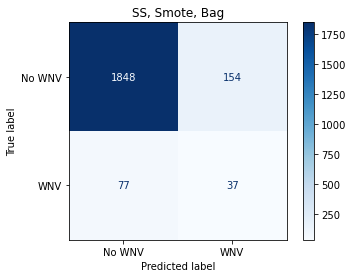

In [54]:
gs_model(gs_ss_smote_bag, 'SS, Smote, Bag')

#### XGBoost Classifier

In [62]:
xgb = XGBClassifier()

pipe_ss_smote_xgb = Pipeline([
    ('ss', ss),
    ('smote', smote),
    ('xgb', xgb)
])

pipe_ss_smote_xgb_params = {
    'ss__with_mean': [True, False], 
    'ss__with_std': [True, False],
    'smote__k_neighbors': [7],  #[7, 9, 11, 13],
    'smote__random_state': [42],
    'smote__n_jobs': [-1],
    'smote__sampling_strategy': ['minority'],
    'xgb__random_state': [42],
    'xgb__n_jobs': [-1],
    'xgb__learning_rate': [0.1], #[0.1, 0.2, 0.3]
    'xgb__objective': ['binary:logistic'],
    'xgb__n_estimators': [300], #[100, 300, 500]
    'xgb__eval_metric': ['auc']
}

gs_ss_smote_xgb = GridSearchCV(
    estimator=pipe_ss_smote_xgb,
    param_grid=pipe_ss_smote_xgb_params,
    scoring='roc_auc',
    cv=5
)

Model Best Params: {'smote__k_neighbors': 7, 'smote__n_jobs': -1, 'smote__random_state': 42, 'smote__sampling_strategy': 'minority', 'ss__with_mean': True, 'ss__with_std': True, 'xgb__eval_metric': 'auc', 'xgb__learning_rate': 0.1, 'xgb__n_estimators': 300, 'xgb__n_jobs': -1, 'xgb__objective': 'binary:logistic', 'xgb__random_state': 42}
Process took 1.2 minutes


,Accuracy,Sensitivity,Specificity,ROC_AUC
Model,,,,
"SS, Smote, Logit-Ridge",72.5,73.7,72.5,0.731
"SS, Smote, Logit-Lasso",73.1,74.6,73.0,0.738
"SS, Smote, Bag",89.1,32.5,92.3,0.624
"SS, Smote, XGBoost",93.3,26.3,97.2,0.617


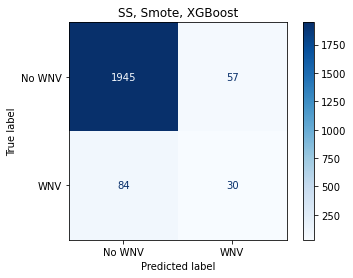

In [63]:
gs_model(gs_ss_smote_xgb, 'SS, Smote, XGBoost')

### Kaggle predictions

In [64]:
duration = time.time()
kaggle_submit = []
kk = 0
def kaggle_test(gs_model):
    for i in range(kaggle_X.shape[0]):
        kaggle_submit.extend([gs_model.best_estimator_.predict_proba(kaggle_X)[i][1]])
        if i % 2000 == 0:
            print(kk)
            print(f'Total time elapsed: {round((time.time()-duration)/60,2)} mins')
            kk += 1

    print(f'Total completion time: {round((time.time() - duration)/60,2)} mins')
    
    kaggle_submit = pd.DataFrame(kaggle_submit)
    kaggle_submit.reset_index(inplace=True)
    kaggle_submit.columns = ['Id', 'WnvPresent']
    kaggle_submit['Id'] = kaggle_submit['Id'] + 1
    kaggle_submit.set_index('Id', inplace=True)
    
    return kaggle_submit


In [ ]:
# Uncomment and fix pathway to run and save above models.
# kaggle_test(gs_ss_smote_logit_lasso)
# kaggle_submit.to_csv(r'../modeling results/gs_ss_smote_logit_lasso.csv')

## Feature extraction 


### Polynomial Features

Any of these features could be related to each other, or have an interactive effect with each other. Any synergistic effect on wnvpresent could increase the significant predictive power to the model. 


In [65]:
# 'nummosquitos' was removed from polynomial features because it is not a feature in the test set
# 'date' was removed as we extracted the 'week', 'year' from it.
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train['wnvpresent']


In [66]:
# Generating the polynomial features table.  
# instantiate
poly = PolynomialFeatures(include_bias=False, degree=2)

# fit and transform the variables in the numerical dataframe
X_poly = poly.fit_transform(X)
X_poly.shape

# Checking column names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X.columns))

# Generating list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

In [67]:
# Shows top 40 features most positively correlated with wnvpresent
X_poly_corrs.sort_values(ascending=False).head(40)

addressaccuracy trap_rank      0.915657
latitude trap_rank             0.912398
trap_rank year                 0.912283
trap_rank                      0.912233
trap_rank sealevel             0.912162
trap_rank stnpressure          0.912148
trap_rank sunset               0.911941
trap_rank week                 0.910168
trap_rank sunrise              0.908579
trap_rank tavg                 0.907355
trap_rank tmin                 0.907185
trap_rank wetbulb              0.907144
trap_rank lag_2_tavg           0.906520
trap_rank tmax                 0.906483
trap_rank dewpoint             0.904773
trap_rank lag_1_tavg           0.904692
trap_rank avgspeed             0.871990
species_nr trap_rank           0.853837
trap_rank resultspeed          0.827764
trap_rank resultdir            0.821981
trap_rank temp_diff            0.792499
trap_rank^2                    0.579206
trap_rank depart               0.571068
trap_rank preciptotal          0.474681
trap_rank TS                   0.461440


The above showed that the highest correlation seemed to be location (trap_rank and addressaccuracy) related. From EDA, we already know that trap_rank has high correlation, and might not be necessary to add another feature related to trap_rank. In addition, nummosquitoes is not in the test set. So we think adding more features related to temperature such as 'species_nr dewpoint', 'tmin sunrise', 'wetbulb sunrise' would increase the predictive power of our model.

It is also important to note features that might have the highest negative impact on wnvpresent. The below list shows that longitude and sunset might have decrease/discourage the presence of wnvpresent. 


In [68]:
# Shows bottom 20 features most positively correlated with wnvpresent
X_poly_corrs.sort_values(ascending=False).tail(20) 

longitude TS           -0.056869
sunset year            -0.057391
sunset                 -0.059019
sunset stnpressure     -0.060200
sunset sealevel        -0.060779
longitude tmax         -0.061344
sunset^2               -0.061918
longitude depart       -0.065620
longitude              -0.076600
longitude FG           -0.077753
longitude temp_diff    -0.078773
longitude tavg         -0.079429
longitude year         -0.080058
longitude tmin         -0.090030
longitude wetbulb      -0.092972
longitude dewpoint     -0.095661
longitude sunrise      -0.098397
longitude week         -0.101082
species_nr longitude   -0.125671
longitude trap_rank    -0.912227
dtype: float64

In [69]:
# Adding interaction features into train set
train['species_nr*dewpoint'] = train['species_nr'] * train['dewpoint']
train['tmin*sunrise'] = train['tmin'] * train['sunrise']
train['wetbulb*sunrise'] = train['wetbulb'] * train['sunrise']


In [70]:
# final train set
train.head()

,date,species_nr,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,trap_rank,tmax,tmin,...,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal,species_nr*dewpoint,tmin*sunrise,wetbulb*sunrise
0,2007-05-29,1.0,41.688324,-87.676709,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
1,2007-05-29,1.0,41.720848,-87.666014,9,3,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
2,2007-05-29,1.0,41.731922,-87.677512,8,5,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
3,2007-05-29,1.0,41.732984,-87.649642,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5
4,2007-05-29,1.0,41.862292,-87.648860,8,1,0,0,88.0,62.5,...,2007.0,0.0,0.0,56.25,73.25,0.345,0.0,58.5,26312.5,27575.5


In [71]:
# Adding interaction features into test set
test['species_nr*dewpoint'] = test['species_nr'] * test['dewpoint']
test['tmin*sunrise'] = test['tmin'] * test['sunrise']
test['wetbulb*sunrise'] = test['wetbulb'] * test['sunrise']


### Exploring PCA-transformed data

Due to the number of features (and high-dimensional manifold) in our dataset, PCA was utilised to perform an unsupervised dimensionality reduction on the training dataset. In such a way, PCA will provide the best linear approximations before modeling and prediction was performed ([source](https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf)). GridSearchCV is used to set the dimensionality of the PCA. 

In [72]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [73]:
X.shape

(8461, 31)

In [74]:
# split again, just to make sure
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42, stratify =y)

# scaling
ss_pca = StandardScaler()

X_train_sc = ss_pca.fit_transform(X_train)
X_valid_sc = ss_pca.transform(X_valid)

In [75]:
# Instantiate PCA.
# up to n_components were tested
pca = PCA(n_components = 10)

# Fit PCA on the training data.
pca.fit(X_train_sc)

PCA(n_components=10)

In the below pipeline, PCA will perform unsupervised dimensionality reduction on the training data before upsampling it. This is so that upsampling will only be performed on the reduced dimensional manifold and not on the entire dataset. The models for the prediction will be done last. In the below pipeline, the logistic regression model was utilised. 

In [76]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA()),
        ('sampling', SMOTE()),
        ('logreg', LogisticRegression(max_iter=1_000, solver='saga'))
    ])

In [77]:
pipe_params = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  
} 

In [78]:
grid = GridSearchCV(pipe, pipe_params, scoring='roc_auc', n_jobs=-1)

In [79]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()), ('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

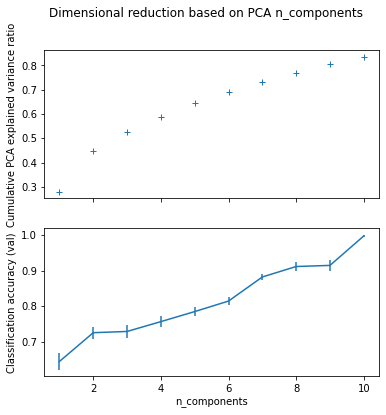

In [80]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py
# Plot search for best combination of PCA n_components and logistic regression accuracy
# pca.fit(X_train_sc)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(), '+', linewidth=10)
ax0.set_ylabel('Cumulative PCA explained variance ratio')

results = pd.DataFrame(grid.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components');
plt.suptitle('Dimensional reduction based on PCA n_components');

In [81]:
print(f'Cumulative explained variance (for n_components=9): {pca.explained_variance_ratio_.cumsum()[9]}')

Cumulative explained variance (for n_components=9): 0.835076244704677


In [82]:
grid.best_params_

{'pca__n_components': 10}

In [83]:
grid.score(X_train, y_train), grid.score(X_valid, y_valid)

(0.9998122834860663, 1.0)

GridSearchCV chose n_components=10, however, there was overfitting at n_components=10. Since PCA utilises n_components, the decision is to use n_components=9, to minimise overfitting, and we would retain approximately 83% of the variability in the data.
<br>
<br> The curse is after the dataset is PCA-transformed, there is no correlation between any features. And to dig into the feature importance, one will have to convert the PCA-transformed data back to the original features.

### Loop models

In [84]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, solver='saga'),
        'dt': DecisionTreeClassifier(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
        'svc': SVC(probability=True),
        } 

In [85]:
def run_models(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = 9)),
            ('sampling', SMOTE(sampling_strategy = 'minority')),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    # metrics
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_valid, y_valid)
    preds = grid.predict(X_valid)
    tn, fp, fn, tp = confusion_matrix(y_valid, preds).ravel()

#     y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
#     y_valid_pred_prob = pipe.predict_proba(X_valid)[:,1]
#     train_auc = roc_auc_score(y_train, y_train_pred_prob)
#     valid_auc = roc_auc_score(y_valid, y_valid_pred_prob)
    
    # View confusion matrix
    plot_confusion_matrix(grid, X_valid, y_valid, cmap='Blues', values_format='d');
    
    # Calculate the sensitivity/ recall
    sens = tp / (tp + fn)
    
    # Calculate the specificity
    spec = tn / (tn + fp) 
    
    # print results
    print(f'Best params: {grid.best_params_}')
    print(f'Training score: {round(train_score, 4)}')
    print(f'Test score: {round(test_score, 4)}')
    print(f'recall: {round(sens, 4)}')
    print(f'specificity: {round(spec, 4)}')
    return grid

**Logistic Regression**

Best params: {'lr__C': 1, 'lr__penalty': 'l1', 'sampling__k_neighbors': 20}
Training score: 0.9167
Test score: 0.9298
recall: 0.8278
specificity: 0.8547


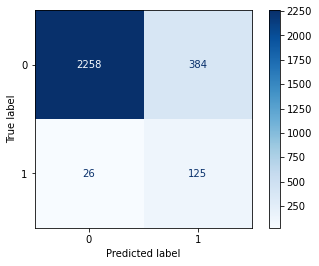

In [90]:
# logistic regression
grid_params = {
    'sampling__k_neighbors': [15, 20, 25],  # recall < 1 above 250
    'lr__penalty': ['l1', 'l2',  'elasticnet'],   
    'lr__C': [0.1, 1, 10]  
} 

best_params = {
    'sampling__k_neighbors': [20],  
    'lr__penalty': ['l1'],   
    'lr__C': [1]  
}

lr = run_models('lr', best_params)


There was little change in tuning the hyperparameters for the logistic regression. There might be an issue with underfitting, since training score < test score. However, it is uncertain (for now) if one of the ways to combat this is to decrease or increase the sampling strategy, since recall was affected, despite having good training and test scores. 'saga' was selected as the 'solver' since it supports several penalties. 'none' was not provided as an option due to tendency of getting training scores = 1.0. So applying regularisation did help to minimise overfitting.

**Decision Tree Classifier**

Best params: {'dt__max_depth': 50, 'dt__min_samples_leaf': 100, 'dt__min_samples_split': 15, 'sampling__k_neighbors': 15}
Training score: 0.9791
Test score: 0.9526
recall: 0.8212
specificity: 0.9614


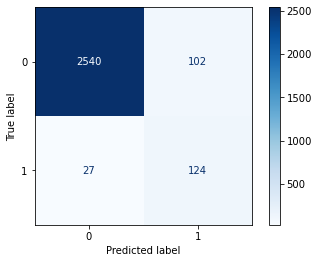

In [113]:
# decision tree classifier
grid_params = {
    'sampling__k_neighbors': [15, 20, 25],  
    'dt__max_depth': [40, 45, 50],
    'dt__min_samples_split': [10, 15, 20],
    'dt__min_samples_leaf': [100, 150, 200],
} 

best_params = {
    'sampling__k_neighbors': [15],  
    'dt__max_depth': [50],
    'dt__min_samples_split': [15],
    'dt__min_samples_leaf': [100],
} 

dt = run_models('dt', best_params)

I do not understand the popularity of decision trees, due to its tendency to overfit, and efforts spent on tuning the parameters to ensure that training score=1.0 does not occur. The hyperparameters are relatively higher (than what I had previously seen), but this was due to training score = 0.999. 'max_depth' is the maximum depth of the tree, where default=None. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. Since GridSearchCV chooses the estimator based on the highest score, one will have to provide restricted ranges such that training score = 0.999 does not occur. 
<br> 
<br> In most parts during hyperparameter selection, there was a balance between providing certain values for GridSearch to tune, such that the higher value of maximum depth does not result in overfitting, and a lower value does not result in underfitting. *(Personal opinion)* higher values should be provided to min_samples_split and min_samples_leaf, however, recall/sensitivity was penalised/reduced. 

**Random forest classifier**

Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 100, 'rf__min_samples_split': 20, 'rf__n_estimators': 35, 'sampling__k_neighbors': 20}
Training score: 0.9853
Test score: 0.9651
recall: 0.8477
specificity: 0.9516


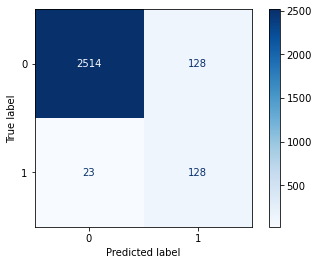

In [109]:
# random forest classifier
grid_params = {
    'sampling__k_neighbors': [15, 20, 25], 
    'rf__n_estimators': [30, 35, 40],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [10, 15, 20],
    'rf__min_samples_leaf': [100, 150, 200],
} 

best_params = {
    'sampling__k_neighbors': [20], 
    'rf__n_estimators': [35],
    'rf__max_depth': [10],
    'rf__min_samples_split': [20],
    'rf__min_samples_leaf': [100],
} 

rf = run_models('rf', best_params)


Ensemble methods are better than simple/one decision tree, due to less probability of overfitting. However, similarly to decision tress (and not totally unexpected), the hyperparameters were relatively higher, but this was due to training score = 0.999. Also (and not totally unexpected), pre-pruning to stop GridSearchCV from growing/cutting down trees was necessary to prevent overfitting. Increasing 'max_depth' would produce better scores; This is not necessary surprising as deeper trees allowed the capture of more information, however, it also increases the likelihood of overfitting. Increasing 'min_samples_leaf' and 'min_samples_split' were essential to ensure that the classifier does not keep splitting the dataset to be more 'pure'. However, there seems to be less issue with recall and specificity in the decision tree and random forests classifiers, compared to logistic regression.

**Feature importance**

While PCA is not a classifier and one does not necessarily need to PCA-transform data to get good results, it is important to note that PCA **can** be useful when one has a dataset with high dimensionality. Being able to identify the dimensions first before applying a classifier, may help to discriminate between the classes better. Here, the Random Forest classifier is used to determine the gini importance of the n_components=9, and each feature is plotted below. 

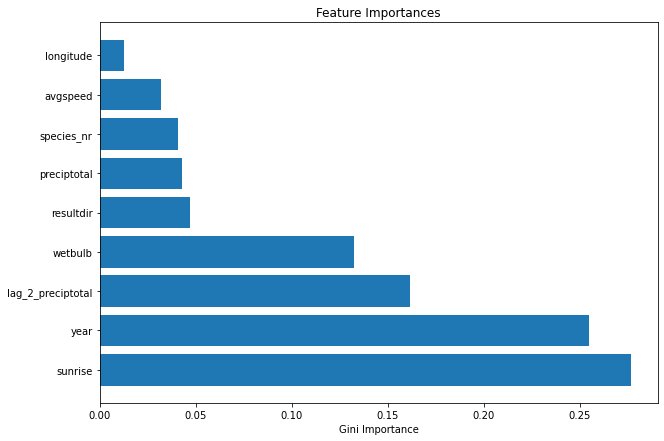

In [114]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# PCA-transform data back to orignal features
num_plot = 9

pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = num_plot)),
            ('sampling', SMOTE(sampling_strategy='minority', k_neighbors=200)),
            ('rf', RandomForestClassifier(n_estimators=350, max_depth=50, min_samples_split = 200, min_samples_leaf = 100)),
            ])

pipe.fit(X_train, y_train)

model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]

# get index for more important feature from each n_component
feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]

# combine for plotting later
zipped_feats = zip(most_important_names, pipe.steps[3][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)

# n_components = 9
top_features = features[:num_plot]
top_importances = importances[:num_plot]
plt.figure(figsize=(10,7))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.title('Feature Importances')
plt.xlabel('Gini Importance')
plt.show() 

In [115]:
# explained variance attribute of each prinicipal component
pipe.steps[1][1].explained_variance_ratio_

array([0.27970555, 0.16607017, 0.0812244 , 0.06197712, 0.05666677,
       0.04404601, 0.04074771, 0.03833562, 0.03544525])

The above plots show the nine highest performing predictors. The explained variance ratio provides the information (variance) that is captured by each principal component. So, 'sunrise' explains approximately 28% of the variance in the dataset. 'year' explains approximately 17% of the variance in the dataset. As demonstrated earlier, n_components=9, could explain approximate 80% of the variability in the dataset.

**year** was a surprise feature. And on hindsight, should have been dropped, if not because we were relying on PCA to transform our entire dataset. How does the year explain 28% of the variability in the dataset? It could be that learning from the past, will bring about wisdom and understanding in the future. During EDA, it was shown that years 2007 and 2013 are years with the highest presence wnv detected. In 2007, a large amount of rain and hot weather produced favourable conditions for eggs ([source](https://www.cmaj.ca/content/177/12/1489.1)). In 2012/2013, was the deadliest year for the wnv in the US due to higher than normal temperatures, and sustained interactions between mosquito and birds (which are reservoir hosts for wnv) ([source](https://www.nbcnews.com/healthmain/2012-was-deadliest-year-west-nile-us-cdc-says-1c9904312))
<br>
<br> **Sunrise** was not a surprise since mosquitoes are most active around the time of sunrise ([source](https://portal.ct.gov/Mosquito/Press-Room/2020-Press-Releases/DPH-Announces-Three-New-Cases-of-West-Nile-Virus-Infection-in-Fairfield-County.)). 
<br>
<br> **lag_2_preciptotal** and **preciptotal** were not surprising features either, since increased precipitation have a lagged effect on wnvpresent ([source](https://pubmed.ncbi.nlm.nih.gov/30145430/)). However, we were expecting more lagged features from temperatures as well.
<br>
<br> **wetbulb** was also discussed in EDA. Since wetbulb takes into account both precipitation and temperature, it has demonstrated to have a higher predictive power since it is a feature engineered through combining temperature and precipitation ([source](https://www.theweatherprediction.com/habyhints/259/)).
<br>
<br> **resultdir** is the resultant wind direction, measured to whole degrees, based on a 360 degree compass (with 0 or 360 degrees from the North). **avgspeed** is the average wind speed. While one would expect higher temperatures and rainfall to dominant the feature importances, it seems *where* and *how fast* the wind is blowing could also be important features. This could be related to FG (fog column)([source](https://www.sciencedaily.com/releases/2012/11/121119104522.htm)), since the spread of wnv requires the mosquitoes to be well conditioned or aided (by wind) for flight.
<br>
<br> We have discussed the top 2 **species_nr** culex pipiens, culex restuans that are responsible for the spread of the wnv in our EDA.
<br>
<br> **longitude** is related to location and possibly where the traps were being placed.


**Extra trees classifier**

Best params: {'et__max_depth': 4, 'et__min_samples_leaf': 10, 'et__min_samples_split': 15, 'et__n_estimators': 30, 'sampling__k_neighbors': 20}
Training score: 0.9459
Test score: 0.9363
recall: 0.8278
specificity: 0.8581


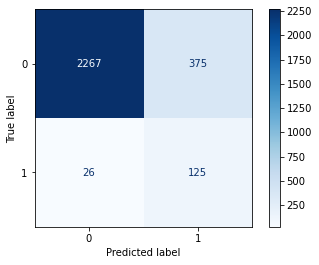

In [116]:
# extra trees classifier
grid_params = {
    'sampling__k_neighbors': [15, 20, 25],
    'et__n_estimators': [30, 35],
    'et__max_depth': [4, 5, 6],
    'et__min_samples_split': [10, 15],
    'et__min_samples_leaf': [10, 15],
} 

best_params = {
    'sampling__k_neighbors': [20],
    'et__n_estimators': [30],  
    'et__max_depth': [4],  
    'et__min_samples_split': [15],
    'et__min_samples_leaf': [10],
}

et = run_models('et', best_params)


Extra trees implements a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset. It should improve the accuracy while control for over-fitting. So far, this has been true; The number of trees are fewer, and do not need to be deep (max_depth) to produce good scores. Increasing the n_estimators also increased the accuracy, but up to a certain point (in this case, 30 trees). min_samples_split and min_samples_leaf do not have to be large to avoid overfitting. Feature importance was not performed because n_components=9 was used for all the models using PCA-transformed data, and they are the same 9 features. *(Preliminary analysis found that sunrise and year would fight to be top dog in the different models, but that was just a small difference)*

**Support Vector Classification**

Best params: {'sampling__k_neighbors': 30, 'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Training score: 0.9236
Test score: 0.934
recall: 0.8278
specificity: 0.8554


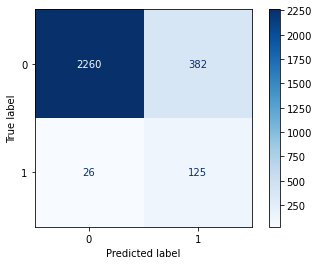

In [121]:
# Support Vector Classification
grid_params = {
    'sampling__k_neighbors': [25, 30],     
    'svc__kernel': ['linear', 'sigmoid'],   
    'svc__gamma' : ['scale', 'auto'], 
    'svc__C': [1 ,5 ,10] 
} 

best_params = {
    'sampling__k_neighbors': [30],     
    'svc__kernel': ['linear'],    
    'svc__gamma' : ['scale'],
    'svc__C': [1] 
} 

svc = run_models('svc',  best_params)


In the above, hyperparameters tuned were the kernel, gamma and regularization parameter. 'rbf' and 'poly' were not provided as options, as there were instances where training score=0.99 (dependent on other parameters). Choosing an optimal gamma was important too, since the parameter controls overfitting; The higher the gamma, the higher the hyperplane to match the training data. A regularization parameter C represents the tradeoff between a smoother hyperplane and misclassifications. In summary, SVM is known to work well with non-linear data, is simple to implement, and provided high accuracy. However, it requires a lot of training time compared to other algorithms. 

### Plot ROC-AUC 

In [122]:
def plot_all_auc(models):
    fig, ax = plt.subplots(figsize=(10,10))
    axes = {}
    for i, m in enumerate(models.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_valid, y_valid, ax=ax, name=models[m])
        
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.title('ROC-AUC curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()

In [123]:
models_built = {
    lr : 'LogisticRegression', 
    dt : 'DecisionTreeClassifier',
    rf : 'RandomForestClassifier',
    et : 'ExtraTreesClassifier',
    svc : 'SVC',
} 

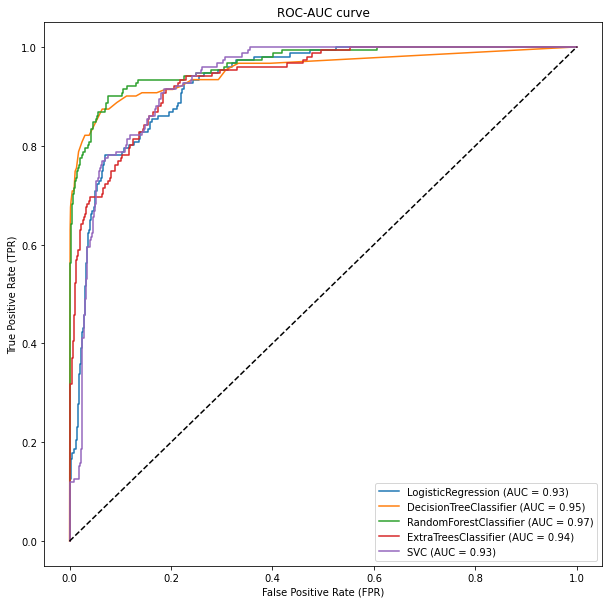

In [124]:
plot_all_auc(models_built)

From the above ROC-AUC curve, the Random Forest classifier has the highest AUC score, ie., it is better at predicting classes or distinguishing between the classes. So the Random Forest model also presents the best performing trade-off between the true positives and true negatives. In addition, the model has a recall rate at 0.85, and specificity at 0.95. Therefore, using PCA-transformed data, **the Random Forest model was selected as the chosen model.**
<br>
<br> At FPR=1, where sensitivity is the highest, all classifiers seemed to performed well till FPR=0.8. Below this point, the decision tree (dt) classifier starts to exhibit lower sensitivity, with the lowest sensitivity (=0.82) reported among all the models. Given the tendency for dt to overfit, the parameters were tuned such that a training score = 0.999 did not occur, however, sensitivity was also penalised. At FPR=0, where specificity is the highest, the sudden decrease in logistic regression showed that the model, together with SVC have the lowest specificity.
<br>
<br> Due to excessive restrictions on overfitting, some models exhibited underfitting. Perhaps depending on PCA to reduce the dimension and transform the data restricted/prevented the model from learning and understanding the complexities of the dataset. In this case, between underfitting and overfitting, the decision here was to restrict overfitting. Due to the multicollinearity of the data, for example, in the weather dataset, where most (if not all) of the dataset are close cousins of each other, the data used should be simplified and this will also enable use of a less complex model. If one can utilise a better dataset with more information on spraying, then this will justify the use of a more complex model.

### Kaggle predictions 

In [125]:
test.head()

,id,date,latitude,longitude,addressaccuracy,species_nr,trap_rank,tmax,tmin,tavg,...,year,FG,TS,lag_1_tavg,lag_2_tavg,lag_1_preciptotal,lag_2_preciptotal,species_nr*dewpoint,tmin*sunrise,wetbulb*sunrise
0,1,2008-06-11,41.95469,-87.800991,9,2.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,111.0,26416.0,26624.0
1,2,2008-06-11,41.95469,-87.800991,9,1.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,55.5,26416.0,26624.0
2,3,2008-06-11,41.95469,-87.800991,9,3.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,166.5,26416.0,26624.0
3,4,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,0.0,26416.0,26624.0
4,5,2008-06-11,41.95469,-87.800991,9,0.0,0,86.0,63.5,74.75,...,2008.0,0.0,0.0,66.5,72.75,0.0,0.095,0.0,26416.0,26624.0


In [126]:
# drop columns
X_test = test.drop(columns=['id','date'])

# check that shape is same to train dataset
X_test.shape

(116293, 31)

In [127]:
X = train.drop(columns=['date','wnvpresent','nummosquitos'])
y = train[['wnvpresent']]

In [128]:
def run_test(model, model_params):
    pipe = Pipeline([
            ('scale', StandardScaler()),
            ('pca', PCA(n_components = 9)),
            ('sampling', SMOTE()),
            (model, models[model])
            ])
    
    grid = GridSearchCV(pipe, param_grid=model_params, scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)

    train_score = grid.score(X, y)
#     preds = grid.predict(X_test)
    pred_prob = grid.predict_proba(X_test)
    
    print(f'Training score: {round(train_score, 4)}')
    return pred_prob

In [129]:
# Random Forest Classification
best_params = {
    'sampling__k_neighbors': [200], 
    'rf__n_estimators': [350],
    'rf__max_depth': [10],
    'rf__min_samples_split': [200],
    'rf__min_samples_leaf': [100],
} 

y_pred = run_test('rf', best_params)

Training score: 0.9859


In [130]:
# y
kaggle_y = test[['id']]
kaggle_y['wnvpresent'] = pd.DataFrame(y_pred[:,1])

**Save predicted results as csv file for kaggle submission.**

In [131]:
kaggle_y.to_csv('../data/kaggle_y.csv',index=False)

### Predicted locations

In [132]:
predictions = pd.read_csv('../data/gs_ss_smote_logit_2.csv')

In [135]:
predict_merge = pd.merge(test, predictions, left_on='id', right_on='Id')

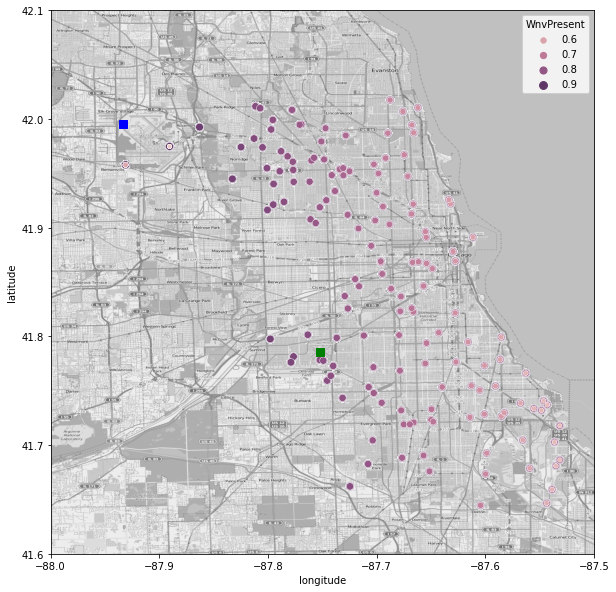

In [136]:
# https://www.kaggle.com/c/predict-west-nile-virus/
# This shows how to read the text representing a map of Chicago in numpy, and put it on a plot in matplotlib.
# This example also rescales the image data to the GPS co-ordinates of the bounding box and overlays some random points.

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# generate some data to overlay
numPoints = 300
lats = predict_merge[predict_merge['WnvPresent'] > 0.5]['latitude']
longs = predict_merge[predict_merge['WnvPresent'] > 0.5]['longitude']
wnv = predict_merge[predict_merge['WnvPresent'] > 0.5]['WnvPresent']

# generate plot
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

station_1 = [41.995, -87.933]  # Co-ords of station 1 (Chicago O'Hare Int'l Airport)
station_2 = [41.786, -87.752]  # Co-ords of station 2 (Chicago Midway Int'l Airport)

# plot colour based on probability values >0.5
sns.scatterplot(x=longs, y=lats, 
                c=wnv,
                hue=wnv, size=wnv,
                s=100)

plt.scatter(x=station_1[1], y=station_1[0], c='b', s=60, marker='s')
plt.scatter(x=station_2[1], y=station_2[0], c='g', s=60, marker='s')

#plt.show()

plt.savefig('map_predict_stn.png')


## <font color=red> Conclusions

(Model) was selected due to several reasons:
* Highest roc_auc accuracy.  The model provide good predicting classes or distinguishing between the classes. 
* The model has high sensitivity, ie., the model has low false negatives. Since predicting mosquitoes to have WNV when they do not (False Positives) is less of a concern than predicting mosquitoes not to have WNV when they actually have it (false negatives). 


**Recommendations**

* New features such as humidity or sunlight duration should be added into the dataset.
* Traps will not be ranked, but dummified, or ranked according to number of mosquitoes caught. Ranking of the traps by groups resulted in overfitting in our models.
* Year could be dropped. Despite year being one of the feature importance in our model (after PCA-transform), the focus should be on weather conditions which will impede/encourage mosquitoes breeding and proliferation, rather than seasonal changes, even if present.
* More information on spraying dataset
* Include migratory patterns of bird (amplifying reservoirs/ hosts for WNV)